In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
from scapy.all import PcapReader

def get_data_transfer_intervals(pcap_file, src_ip, interval_ms=100, total_duration=100):
    """
    Process a PCAP file and calculate the amount of data transferred 
    by the specified source IP in each time interval up to total_duration seconds.
    """
    packets = PcapReader(pcap_file)
    interval_duration = interval_ms / 1000  # Convert to seconds
    num_intervals = int(total_duration / interval_duration)  # Number of intervals
    
    packet_counts = [0] * num_intervals  # Pre-fill list with zeros
    
    start_time = None
    for packet in packets:
        if packet.haslayer("IP") and packet["IP"].src == src_ip and len(packet) == 1514:
            if start_time is None:
                start_time = packet.time  # Set start time based on the first valid packet

            packet_time = packet.time - start_time  # Normalize timestamps
            if 0 <= packet_time < total_duration:
                interval_index = int(packet_time / interval_duration)
                packet_counts[interval_index] += 15140  # Multiply by 10 to get bits

    return packet_counts


In [4]:
import math
from matplotlib.ticker import FuncFormatter

def plot_timeline(pkt_timelines, client_ips=None, interval_ms=100):
    min_length = min(len(pkt) for pkt in pkt_timelines)  # Find shortest dataset length
    x = [i * (interval_ms / 1000) for i in range(min_length)]  # Match x to shortest dataset
    datasets = [[pkt[i] / 1e6 * 8 for i in range(min_length)] for pkt in pkt_timelines]
    titles = client_ips if client_ips else [f"Client {i+1}" for i in range(len(pkt_timelines))]
    
    fig, axs = plt.subplots(len(pkt_timelines), 1, figsize=(6, 10), sharex=True)
    if len(pkt_timelines) == 1:
        axs = [axs]  # Ensure axs is always iterable
    
    for i in range(len(datasets)):
        axs[i].plot(x, datasets[i], color='black', linestyle='-', linewidth=1)
        axs[i].set_title(titles[i])
        axs[i].grid(True, linestyle="--", alpha=0.5)
        axs[i].set_ylim(0, 50)
        axs[i].set_yticks([0, 25, 50])
    
    def format_x_tick(value, _):
        return f"{value:.1f}"
    
    axs[-1].xaxis.set_major_formatter(FuncFormatter(format_x_tick))
    fig.text(0.04, 0.5, "Throughput (Mbps)", va="center", rotation="vertical", fontsize=12)
    plt.xlabel("Time (s)")
    plt.tight_layout()
    plt.show()


In [5]:
def throughput_plot(packet_counts_list, interval_ms=100):
    min_length = min(len(pkt) for pkt in packet_counts_list)  # Find shortest dataset length
    x = [i * (interval_ms / 1000) for i in range(min_length)]  # Time in seconds
    total_throughput = [sum(pkt[i] for pkt in packet_counts_list) for i in range(min_length)]  # Sum across clients
    
    plt.figure(figsize=(8, 4))
    plt.plot(x, total_throughput, color='blue', linestyle='-', linewidth=1)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.xlabel("Time (s)")
    plt.ylabel("Total Throughput (Bytes/s)")
    plt.title("Aggregated Throughput Over 100s")
    plt.show()

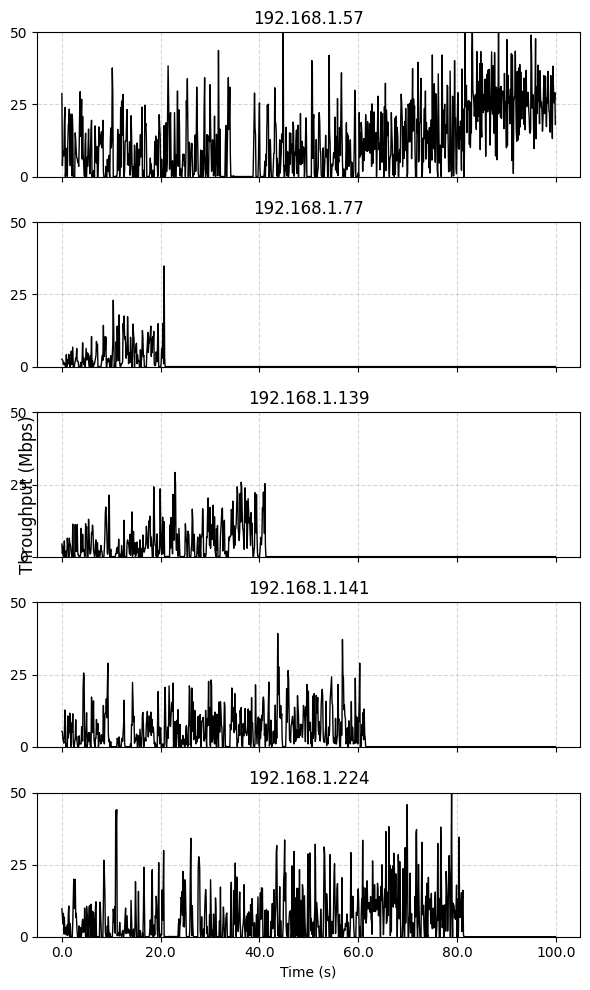

In [6]:
pcap_files = ["out_57.pcap", "out_77.pcap", "out_139.pcap", "out_141.pcap", "out_224.pcap"]
src_ips = ["192.168.1.57", "192.168.1.77", "192.168.1.139", "192.168.1.141", "192.168.1.224"]
interval_ms = 100

packet_counts_list = []

for pcap_file, src_ip in zip(pcap_files, src_ips):
    packet_counts = list(get_data_transfer_intervals(pcap_file, src_ip, interval_ms))  # Ensure it's a list
    packet_counts_list.append(packet_counts)

plot_timeline(packet_counts_list, src_ips, interval_ms)  # Pass all data at once


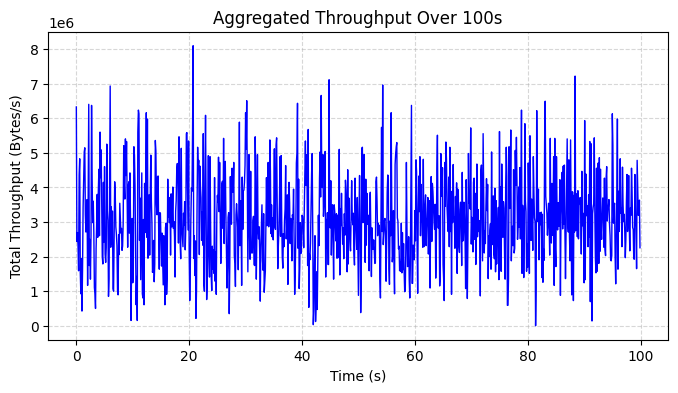

In [7]:
throughput_plot(packet_counts_list, interval_ms)

In [8]:
def compute_throughput_fractions(packet_counts_list, interval_ms=100):
    intervals = [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)]
    interval_size = int((intervals[0][1] - intervals[0][0]) * (1000 / interval_ms))  # Number of points per interval
    
    for start, end in intervals:
        start_idx = int(start * (1000 / interval_ms))
        end_idx = int(end * (1000 / interval_ms))
        
        total_bytes = sum(sum(pkt[start_idx:end_idx]) for pkt in packet_counts_list)
        print(f"Time Interval {start}-{end} seconds:")
        
        if total_bytes == 0:
            print("  No data transferred in this interval.")
        else:
            for i, pkt in enumerate(packet_counts_list):
                client_bytes = sum(pkt[start_idx:end_idx])
                fraction = (client_bytes / total_bytes) * 100 if total_bytes > 0 else 0
                print(f"  Client {i+1}: {fraction:.2f}%")
        print()

In [9]:
compute_throughput_fractions(packet_counts_list, interval_ms)

Time Interval 0-20 seconds:
  Client 1: 32.80%
  Client 2: 15.67%
  Client 3: 14.55%
  Client 4: 18.20%
  Client 5: 18.79%

Time Interval 20-40 seconds:
  Client 1: 26.59%
  Client 2: 1.51%
  Client 3: 28.09%
  Client 4: 24.73%
  Client 5: 19.08%

Time Interval 40-60 seconds:
  Client 1: 33.40%
  Client 2: 0.00%
  Client 3: 2.87%
  Client 4: 34.27%
  Client 5: 29.45%

Time Interval 60-80 seconds:
  Client 1: 54.08%
  Client 2: 0.00%
  Client 3: 0.00%
  Client 4: 2.27%
  Client 5: 43.65%

Time Interval 80-100 seconds:
  Client 1: 97.33%
  Client 2: 0.00%
  Client 3: 0.00%
  Client 4: 0.00%
  Client 5: 2.67%

